# 📐 Understanding the New MDP Formulation

This notebook helps you understand the refactored system:
- **Net Inventory**: I = on_hand - backorders (can be negative!)
- **Frame Stacking**: Stack k=3 historical observations
- **Bounded Actions**: Q_max = 20 units per product

Keep it simple - just explore and visualize!

## Setup

In [1]:
import sys
sys.path.insert(0, '../..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 4)

## 🎯 Part 1: Understanding Observations

**Observation** = snapshot of the system at one point in time

**o_t = (I₀, O₀, I₁, O₁)**

Where:
- **I_j**: Net inventory (positive = on-hand, negative = backorders)
- **O_j**: Outstanding orders (in-transit)

In [2]:
from src.mdp import create_observation

# Example 1: Healthy inventory
obs1 = create_observation(
    net_inventory_0=40,    # 40 units on-hand
    net_inventory_1=50,    # 50 units on-hand
    outstanding_0=10,      # 10 units in-transit
    outstanding_1=15       # 15 units in-transit
)

print("Example 1: Healthy Inventory")
print(f"  Net inventory: {obs1.net_inventory}")
print(f"  Outstanding: {obs1.outstanding_orders}")
print(f"\n  Product 0:")
print(f"    On-hand: {obs1.get_on_hand_inventory(0)}")
print(f"    Backorders: {obs1.get_backorders(0)}")
print(f"    Inventory Position: {obs1.get_inventory_position(0)}")
print(f"\n💡 Inventory Position = Net Inventory + Outstanding")
print(f"   Product 0: {obs1.net_inventory[0]} + {obs1.outstanding_orders[0]} = {obs1.get_inventory_position(0)}")

Example 1: Healthy Inventory
  Net inventory: (40, 50)
  Outstanding: (10, 15)

  Product 0:
    On-hand: 40
    Backorders: 0
    Inventory Position: 50

💡 Inventory Position = Net Inventory + Outstanding
   Product 0: 40 + 10 = 50


In [3]:
# Example 2: Stockout situation (NEGATIVE net inventory)
obs2 = create_observation(
    net_inventory_0=-20,   # 20 units backordered!
    net_inventory_1=-10,   # 10 units backordered!
    outstanding_0=30,      # Emergency order placed
    outstanding_1=25       # Emergency order placed
)

print("\nExample 2: Stockout (Negative Net Inventory)")
print(f"  Net inventory: {obs2.net_inventory}")
print(f"  Outstanding: {obs2.outstanding_orders}")
print(f"\n  Product 0:")
print(f"    On-hand: {obs2.get_on_hand_inventory(0)} (none!)")
print(f"    Backorders: {obs2.get_backorders(0)} (customers waiting!)")
print(f"    Inventory Position: {obs2.get_inventory_position(0)}")
print(f"\n💡 When net_inventory < 0:")
print(f"   - On-hand = 0 (no physical inventory)")
print(f"   - Backorders = |net_inventory| (unfulfilled demand)")


Example 2: Stockout (Negative Net Inventory)
  Net inventory: (-20, -10)
  Outstanding: (30, 25)

  Product 0:
    On-hand: 0 (none!)
    Backorders: 20 (customers waiting!)
    Inventory Position: 10

💡 When net_inventory < 0:
   - On-hand = 0 (no physical inventory)
   - Backorders = |net_inventory| (unfulfilled demand)


### Visualize Net Inventory Concept

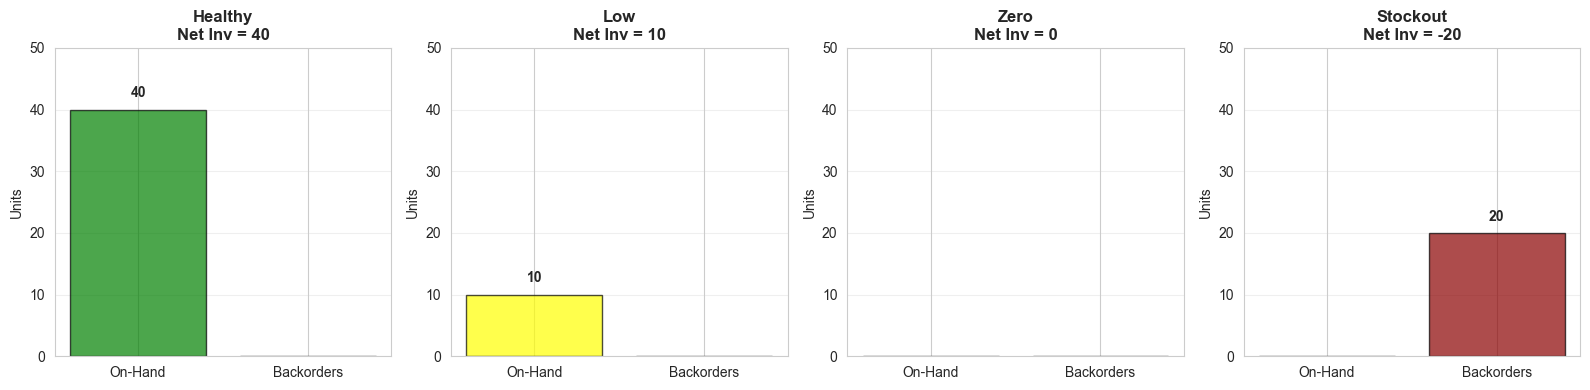


✓ Key insight: Net inventory can be negative!
  This elegantly represents stockout situations.


In [4]:
# Show different net inventory scenarios
scenarios = [
    (40, "Healthy", "green"),
    (10, "Low", "yellow"),
    (0, "Zero", "orange"),
    (-20, "Stockout", "red")
]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for idx, (net_inv, label, color) in enumerate(scenarios):
    obs = create_observation(net_inv, 50, 10, 10)
    
    # Bar for on-hand vs backorders
    on_hand = obs.get_on_hand_inventory(0)
    backorders = obs.get_backorders(0)
    
    axes[idx].bar(['On-Hand', 'Backorders'], [on_hand, backorders], 
                  color=[color, 'darkred'], alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'{label}\nNet Inv = {net_inv}', fontweight='bold')
    axes[idx].set_ylabel('Units')
    axes[idx].set_ylim(0, 50)
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add text annotations
    if on_hand > 0:
        axes[idx].text(0, on_hand + 2, str(on_hand), ha='center', fontweight='bold')
    if backorders > 0:
        axes[idx].text(1, backorders + 2, str(backorders), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Key insight: Net inventory can be negative!")
print("  This elegantly represents stockout situations.")

## 🎬 Part 2: Understanding Frame Stacking

**Problem**: Lead times are unobservable → POMDP

**Solution**: Stack k=3 historical observations → approximate MDP

**State** = [o_t, o_{t-1}, o_{t-2}, o_{t-3}]

This allows the agent to infer dynamics from history!

In [5]:
from src.mdp import create_initial_state, update_state_with_observation

# Create initial state (same observation repeated k+1 times)
state = create_initial_state(
    net_inventory_0=50,
    net_inventory_1=50,
    k=3  # Stack 4 observations (current + 3 historical)
)

print("Initial State (frame stacking):")
print(f"  Number of frames: {len(state.observations)}")
print(f"  k (historical frames): {state.k}")
print(f"  State dimension: {state.shape}")
print(f"\n  Current observation: {state.current_observation.net_inventory}")
print(f"  Oldest observation: {state.observations[-1].net_inventory}")
print("\n💡 State = [o_t, o_{t-1}, o_{t-2}, o_{t-3}]")
print(f"   Dimension: 4 frames × 4 features = 16D")

Initial State (frame stacking):
  Number of frames: 4
  k (historical frames): 3
  State dimension: (16,)

  Current observation: (50, 50)
  Oldest observation: (50, 50)

💡 State = [o_t, o_{t-1}, o_{t-2}, o_{t-3}]
   Dimension: 4 frames × 4 features = 16D


In [6]:
# Simulate state evolution over time
print("\nSimulating state evolution:")
print("="*60)

current_state = state

# Time t=1: Demand arrives, inventory decreases
obs_t1 = create_observation(45, 48, 0, 0)
state_t1 = update_state_with_observation(current_state, obs_t1)

print("\nTime t=1: Demand arrived")
print(f"  New observation: net_inv={obs_t1.net_inventory}")
print(f"  State frames:")
for i, obs in enumerate(state_t1.observations):
    age = "current" if i == 0 else f"t-{i}"
    print(f"    [{age}]: {obs.net_inventory}")

# Time t=2: Place order
obs_t2 = create_observation(40, 43, 20, 15)  # Outstanding increased!
state_t2 = update_state_with_observation(state_t1, obs_t2)

print("\nTime t=2: Order placed (outstanding increased)")
print(f"  New observation: net_inv={obs_t2.net_inventory}, out={obs_t2.outstanding_orders}")
print(f"  State frames:")
for i, obs in enumerate(state_t2.observations):
    age = "current" if i == 0 else f"t-{i}"
    print(f"    [{age}]: net_inv={obs.net_inventory}, out={obs.outstanding_orders}")

# Time t=3: Order arrives!
obs_t3 = create_observation(55, 53, 0, 0)  # Outstanding back to 0, inventory up!
state_t3 = update_state_with_observation(state_t2, obs_t3)

print("\nTime t=3: Order arrived! (outstanding → 0, inventory ↑)")
print(f"  New observation: net_inv={obs_t3.net_inventory}, out={obs_t3.outstanding_orders}")
print(f"  State frames:")
for i, obs in enumerate(state_t3.observations):
    age = "current" if i == 0 else f"t-{i}"
    print(f"    [{age}]: net_inv={obs.net_inventory}, out={obs.outstanding_orders}")

print("\n💡 Agent can learn from history:")
print("   - At t=2: Outstanding increased to (20, 15)")
print("   - At t=3: Outstanding back to (0, 0) and inventory increased")
print("   - Conclusion: Orders typically arrive within 1 day!")


Simulating state evolution:

Time t=1: Demand arrived
  New observation: net_inv=(45, 48)
  State frames:
    [current]: (45, 48)
    [t-1]: (50, 50)
    [t-2]: (50, 50)
    [t-3]: (50, 50)

Time t=2: Order placed (outstanding increased)
  New observation: net_inv=(40, 43), out=(20, 15)
  State frames:
    [current]: net_inv=(40, 43), out=(20, 15)
    [t-1]: net_inv=(45, 48), out=(0, 0)
    [t-2]: net_inv=(50, 50), out=(0, 0)
    [t-3]: net_inv=(50, 50), out=(0, 0)

Time t=3: Order arrived! (outstanding → 0, inventory ↑)
  New observation: net_inv=(55, 53), out=(0, 0)
  State frames:
    [current]: net_inv=(55, 53), out=(0, 0)
    [t-1]: net_inv=(40, 43), out=(20, 15)
    [t-2]: net_inv=(45, 48), out=(0, 0)
    [t-3]: net_inv=(50, 50), out=(0, 0)

💡 Agent can learn from history:
   - At t=2: Outstanding increased to (20, 15)
   - At t=3: Outstanding back to (0, 0) and inventory increased
   - Conclusion: Orders typically arrive within 1 day!


### Visualize Frame Stack

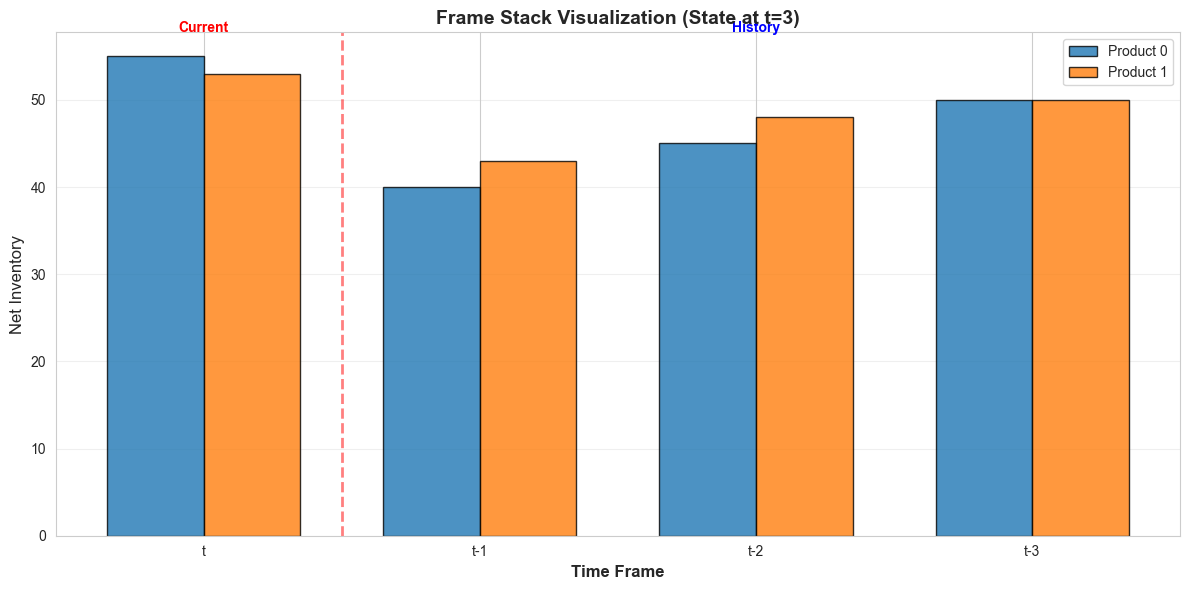


✓ Frame stacking allows agent to see temporal patterns!


In [7]:
# Visualize the frame stack
fig, ax = plt.subplots(figsize=(12, 6))

# Extract data for visualization
frames = ['t', 't-1', 't-2', 't-3']
net_inv_0 = [obs.net_inventory[0] for obs in state_t3.observations]
net_inv_1 = [obs.net_inventory[1] for obs in state_t3.observations]

x = np.arange(len(frames))
width = 0.35

ax.bar(x - width/2, net_inv_0, width, label='Product 0', alpha=0.8, edgecolor='black')
ax.bar(x + width/2, net_inv_1, width, label='Product 1', alpha=0.8, edgecolor='black')

ax.set_xlabel('Time Frame', fontsize=12, fontweight='bold')
ax.set_ylabel('Net Inventory', fontsize=12)
ax.set_title('Frame Stack Visualization (State at t=3)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(frames)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add annotations
ax.axvline(x=0.5, color='red', linestyle='--', linewidth=2, alpha=0.5)
ax.text(0, max(net_inv_0 + net_inv_1) * 1.05, 'Current', ha='center', fontweight='bold', color='red')
ax.text(2, max(net_inv_0 + net_inv_1) * 1.05, 'History', ha='center', fontweight='bold', color='blue')

plt.tight_layout()
plt.show()

print("\n✓ Frame stacking allows agent to see temporal patterns!")

## 💰 Part 3: Understanding Actions & Costs

**Action** = (q₀, q₁) where each q ∈ [0, 20]

**Bounded**: Maximum 20 units per product per day

**Total actions**: 21 × 21 = 441

In [8]:
from src.mdp import ActionSpace, order_both_products, no_order_action

# Create action space with Q_max = 20
action_space = ActionSpace(Q_max=20)

print("Action Space:")
print(f"  Q_max: {action_space.Q_max}")
print(f"  Total actions: {action_space.n}")
print(f"  Calculation: (Q_max + 1)² = (20 + 1)² = 441")

# Example actions
action1 = no_order_action()
action2 = order_both_products(10, 15)
action3 = order_both_products(20, 20)  # Maximum

print(f"\nExample Actions:")
print(f"  1. {action1.order_quantities} - Do nothing")
print(f"  2. {action2.order_quantities} - Moderate order")
print(f"  3. {action3.order_quantities} - Maximum order")

print(f"\n💡 Why bounded?")
print(f"   - Smaller action space → faster learning")
print(f"   - More realistic (supplier constraints)")
print(f"   - Hyperparameter to tune")

Action Space:
  Q_max: 20
  Total actions: 441
  Calculation: (Q_max + 1)² = (20 + 1)² = 441

Example Actions:
  1. (0, 0) - Do nothing
  2. (10, 15) - Moderate order
  3. (20, 20) - Maximum order

💡 Why bounded?
   - Smaller action space → faster learning
   - More realistic (supplier constraints)
   - Hyperparameter to tune


### Visualize Action Space

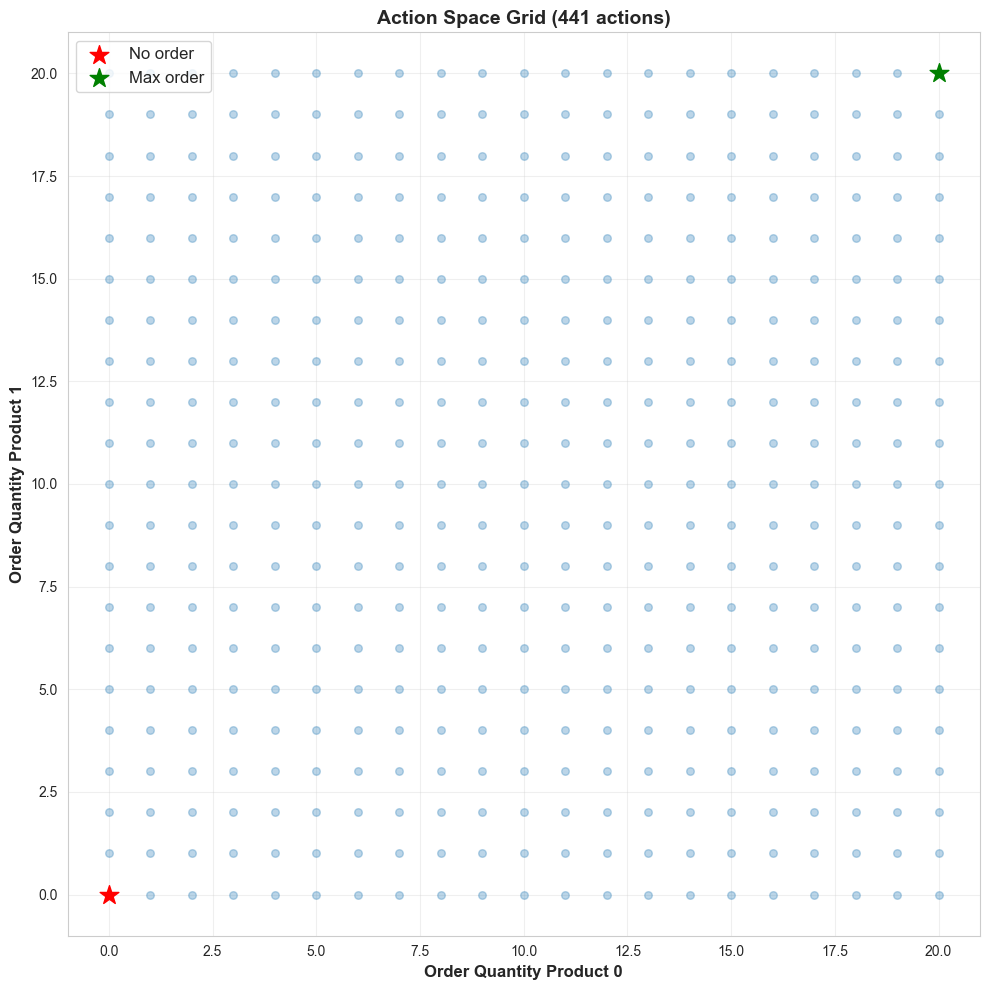

✓ Each point is a possible action!


In [9]:
# Visualize action space as a grid
actions_prod0 = [a.order_quantities[0] for a in action_space.actions]
actions_prod1 = [a.order_quantities[1] for a in action_space.actions]

plt.figure(figsize=(10, 10))
plt.scatter(actions_prod0, actions_prod1, alpha=0.3, s=30)
plt.xlabel('Order Quantity Product 0', fontsize=12, fontweight='bold')
plt.ylabel('Order Quantity Product 1', fontsize=12, fontweight='bold')
plt.title(f'Action Space Grid ({action_space.n} actions)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xlim(-1, 21)
plt.ylim(-1, 21)

# Highlight special actions
plt.scatter([0], [0], color='red', s=200, marker='*', label='No order', zorder=5)
plt.scatter([20], [20], color='green', s=200, marker='*', label='Max order', zorder=5)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

print("✓ Each point is a possible action!")

### Calculate Costs

In [10]:
from src.mdp import CostParameters, StandardRewardFunction

# Cost parameters from assignment
params = CostParameters(K=10, i=3, h=1, pi=7)
reward_fn = StandardRewardFunction(params)

print("Cost Parameters:")
print(f"  K (fixed ordering cost) = ${params.K}")
print(f"  i (unit purchase cost) = ${params.i}")
print(f"  h (holding cost) = ${params.h} per unit per day")
print(f"  π (shortage penalty) = ${params.pi} per unit per day")
print(f"\n💡 Notice: Shortage penalty is 7× higher than holding!")

Cost Parameters:
  K (fixed ordering cost) = $10
  i (unit purchase cost) = $3
  h (holding cost) = $1 per unit per day
  π (shortage penalty) = $7 per unit per day

💡 Notice: Shortage penalty is 7× higher than holding!


In [11]:
# Scenario 1: Normal inventory
obs1 = create_observation(40, 45, 0, 0)  # Healthy
action1 = order_both_products(10, 10)

costs1 = reward_fn.calculate_costs(obs1, action1)

print("Scenario 1: Healthy Inventory + Order")
print(f"  Net inventory: {obs1.net_inventory}")
print(f"  Action: order {action1.order_quantities}")
print(f"\n  Costs:")
print(f"    Ordering: ${costs1.ordering_cost:.2f} = 2×(K + i×10) = 2×(10 + 30)")
print(f"    Holding: ${costs1.holding_cost:.2f} = h×(40 + 45)")
print(f"    Shortage: ${costs1.shortage_cost:.2f} (no backorders)")
print(f"    TOTAL: ${costs1.total_cost:.2f}")

Scenario 1: Healthy Inventory + Order
  Net inventory: (40, 45)
  Action: order (10, 10)

  Costs:
    Ordering: $80.00 = 2×(K + i×10) = 2×(10 + 30)
    Holding: $85.00 = h×(40 + 45)
    Shortage: $0.00 (no backorders)
    TOTAL: $165.00


In [12]:
# Scenario 2: Stockout!
obs2 = create_observation(-20, -15, 0, 0)  # Negative = backorders!
action2 = order_both_products(20, 20)  # Emergency order

costs2 = reward_fn.calculate_costs(obs2, action2)

print("Scenario 2: STOCKOUT + Emergency Order")
print(f"  Net inventory: {obs2.net_inventory} ⚠️ NEGATIVE!")
print(f"  Backorders: ({obs2.get_backorders(0)}, {obs2.get_backorders(1)})")
print(f"  Action: order {action2.order_quantities}")
print(f"\n  Costs:")
print(f"    Ordering: ${costs2.ordering_cost:.2f} = 2×(K + i×20)")
print(f"    Holding: ${costs2.holding_cost:.2f} (no on-hand inventory)")
print(f"    Shortage: ${costs2.shortage_cost:.2f} = π×(20 + 15) ⚠️⚠️")
print(f"    TOTAL: ${costs2.total_cost:.2f}")
print(f"\n💡 Stockout costs are HUGE! Must avoid them!")

Scenario 2: STOCKOUT + Emergency Order
  Net inventory: (-20, -15) ⚠️ NEGATIVE!
  Backorders: (20, 15)
  Action: order (20, 20)

  Costs:
    Ordering: $140.00 = 2×(K + i×20)
    Holding: $0.00 (no on-hand inventory)
    Shortage: $245.00 = π×(20 + 15) ⚠️⚠️
    TOTAL: $385.00

💡 Stockout costs are HUGE! Must avoid them!


### Compare Scenarios

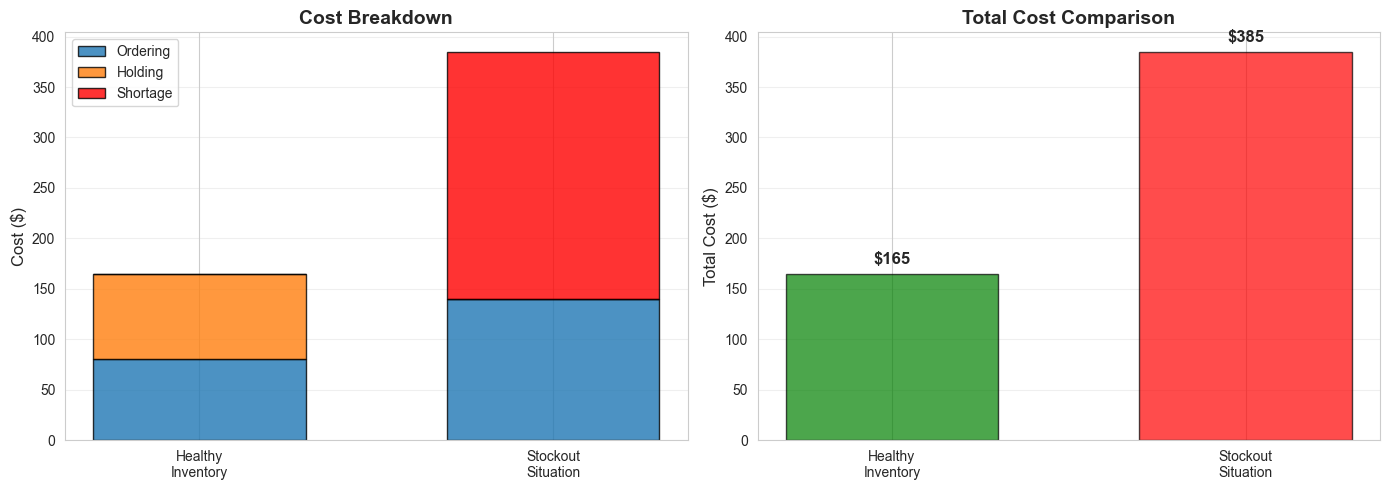


✓ Stockout costs 2.3× more!
  RL agent will learn to avoid stockouts.


In [13]:
# Compare costs
scenarios = ['Healthy\nInventory', 'Stockout\nSituation']
costs_list = [costs1, costs2]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar
ordering = [c.ordering_cost for c in costs_list]
holding = [c.holding_cost for c in costs_list]
shortage = [c.shortage_cost for c in costs_list]

x = np.arange(len(scenarios))
width = 0.6

axes[0].bar(x, ordering, width, label='Ordering', alpha=0.8, edgecolor='black')
axes[0].bar(x, holding, width, bottom=ordering, label='Holding', alpha=0.8, edgecolor='black')
axes[0].bar(x, shortage, width, bottom=np.array(ordering)+np.array(holding), 
            label='Shortage', alpha=0.8, edgecolor='black', color='red')

axes[0].set_ylabel('Cost ($)', fontsize=12)
axes[0].set_title('Cost Breakdown', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(scenarios)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Total comparison
totals = [c.total_cost for c in costs_list]
colors = ['green', 'red']
bars = axes[1].bar(scenarios, totals, color=colors, alpha=0.7, edgecolor='black', width=0.6)
axes[1].set_ylabel('Total Cost ($)', fontsize=12)
axes[1].set_title('Total Cost Comparison', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Add values
for bar, cost in zip(bars, totals):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 10,
                f'${cost:.0f}', ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\n✓ Stockout costs {costs2.total_cost/costs1.total_cost:.1f}× more!")
print(f"  RL agent will learn to avoid stockouts.")

## 🎯 Summary

**What you learned:**

1. **Net Inventory** = On-hand - Backorders
   - Positive: physical inventory
   - Negative: unfulfilled demand (backorders)
   - Elegant representation!

2. **Frame Stacking** = [o_t, o_{t-1}, o_{t-2}, o_{t-3}]
   - Approximate Markov property
   - Agent can infer lead times from history
   - 16D state (4 frames × 4 features)

3. **Bounded Actions** = q ∈ [0, 20]
   - 441 total actions
   - Hyperparameter to tune (Q_max)
   - Smaller space → faster learning

4. **Costs**:
   - Ordering: K + i×q (K=10, i=3)
   - Holding: h×I⁺ (h=1)
   - Shortage: π×|I⁻| (π=7) ← **Very expensive!**

**Key insight**: Stockouts are 7× more expensive than holding. RL agent must balance:
- Order too little → stockouts → huge costs
- Order too much → holding costs + ordering costs

**Next**: See how the system evolves (simulation)